### Interest Rate Derivatives

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import norm

sns.set_style('darkgrid')

### Swaps

The following function computes the swap-rate $X$ at the times 
$$0\leq t_1 < t_2 < \cdots < t_n$$

in terms of the zero-coupon bonds $P_i.$ It also computes the annuity of the swap, which is given by 

$$B = \sum_{i=1}^{n}(t_i - t_{i-1})P_i.$$

We assume that the time steps $t_i - t_{i-1}$ are constant. The periodicity is then defined to be $12(t_i - t_{i-1}).$

The fomula above is for a starting time $t_0$ and end time $t_n,$ but the function below works for any starting and ending times.

In [2]:
# Swap-rate formulas

def SR(per, start, duration, discount):
    # per: periodicity in months (divisible by 12)
    # start: starting year (nonnegative integer)
    # duration: length of the contract in years
    # discount: vector of length  at least (12 x duration / per) + 1 of the zero-coupon bonds, with periodicity per
    step = per/12 # interval lengths
    n = int(duration/step + 1)
    times = list(map(lambda j: start + j*step, range(n)))
    annuity = 0
    for j in range(1,n):
        annuity = annuity + step*discount[int(start/step) + j]
        # print(annuity)
    swap_rate = (discount[int(start/step)] - discount[int(start/step) + n-1])/annuity
    return swap_rate

### Example

As an example suppose we are given the following zero-coupon bonds:

P = [1, 0.975609756, 0.949991019, 0.923971427, 0.898032347, 0.872449235, 0.847375747, 0.822893781, 0.799043132]

and cansider a swap contract with periodicity of 6 months (i.e., time step of 0.5.) starting in year 1 and lasting for three years. The swap-rate has present value given below:

In [3]:
P = [1, 0.975609756, 0.949991019, 0.923971427, 0.898032347, 0.872449235, 0.847375747, 0.822893781, 0.799043132]
SR(6, 1, 3, P)

0.05846426684549076

### Swaptions

Next we consider caplets, floorlets, and swaptions. The function below computes a payers swaption as a function of annuity $B_0,$ swap-rate $X_0,$ strike rate $K,$ volatility $\sigma,$ and expiry time $T_1.$ The expiration of the swaption is the beginning of the swap contract (if exercised.)  

The value of the swaption is given by

$$O_0 = B_0 \mathbb{E}(\max\left\{X_t-K, 0\right\}) = B_0 (X_0N(d_1)-KN(d_2)).$$


In [5]:
def payers_swaption(B, X, K, sig, T1):
    d = [0,0]
    for j in [1,2]:
        d[j-1] = (np.log(X/K)-(-1)**j*0.5*sig**2*T1)/(sig*np.sqrt(T1))
    O = B*(X*norm.cdf(d[0])-K*norm.cdf(d[1]))
    return O

### Example

The result $O$ should be interpreted as the reduction in interest rate payed by the buyer as a result of swapping a variable interest rate for a fixed interest rate.

Below we consider a swaption with annuity 2.5818828345, swap-rate 0.05846426684549076, strike rate 0.05, volatility 0.1 and expity time $T_1 = 1.$

In [18]:
buyers_swaption(2.5818828345, 0.05846426684549076, 0.05, 0.1, 1)

np.float64(0.022206487402071703)

### Monte Carlo methods

Below is a GBM function for swap-rates

In [2]:
def GBM_SR(X0, sigma, T1, n_sims, n_steps):
    """Simulates X_t as geometric Brownian Motions
    Inputs:
    X0 (float): swap rate at time 0
    sigma (float): Yearly volatility
    T1 (float): Time the swaption agreement begins (years)
    n_sims (int): Number of simulated paths
    n_steps (int): Number of steps in each simulated path, each step interval has length t/n_steps
    
    Return (np.array): Array of stock paths
    """
    
    dt = T1/n_steps
    
    noise = np.random.normal(loc = 0, scale = 1, size =(n_sims, n_steps))
    
    log_returns = (- (0.5)*sigma**2)*dt + sigma*np.sqrt(dt)*noise
    
    exponent = np.cumsum(log_returns, axis = 1)
    
    stock_paths = X0*np.exp(exponent)
    
    stock_paths_with_start = np.insert(stock_paths, 0, X0, axis = 1)
    
    return stock_paths_with_start

### Test GBM_SR

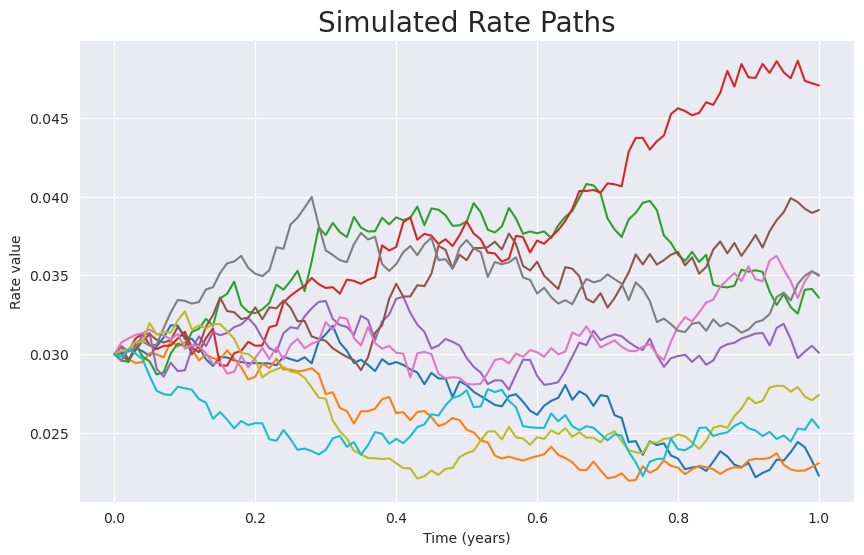

In [3]:
X0 = 0.03
sigma = 0.2
T1 = 1
n_sims = 10
n_steps = 100

paths = GBM_SR(X0, sigma, T1, n_sims, n_steps)
times = np.linspace(0, T1, n_steps+1)

plt.figure(figsize=(10,6))
for path in paths:
    plt.plot(times, path)
plt.xlabel('Time (years)')

plt.ylabel('Rate value')
plt.title('Simulated Rate Paths', size = 20)
plt.show()

Below we price a swaption using MC methods

In [24]:
X0 = 0.03
B0 = 0.035
K = 0.025
sigma = 0.2
T1 = 1
n_steps = 100 

simulation_amounts = [10, 100, 1000, 10000, 100000]

for n_sims in simulation_amounts:

    paths = GBM_SR(X0, sigma, T1, n_sims, n_steps)


    endpoints = paths[:,-1] #Only care about the endpoint


    SR_values = np.maximum(endpoints - K, 0)


    swaption_estimate = B0*np.mean(SR_values)


    std_err = np.std(SR_values)/np.sqrt(n_sims)


    print(f'Swaption estimate with {n_sims} simulations: {swaption_estimate:.8f} and standard error {std_err:.5f}')

    print('-'*100)

    print(f'Black Value: {payers_swaption(B0, X0, K, sigma, T1):.8f}')
    
    
    print('-'*100)
    print('-'*100)

Swaption estimate with 10 simulations: 0.00020234 and standard error 0.00147
----------------------------------------------------------------------------------------------------
Black Value: 0.00019379
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Swaption estimate with 100 simulations: 0.00020393 and standard error 0.00056
----------------------------------------------------------------------------------------------------
Black Value: 0.00019379
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Swaption estimate with 1000 simulations: 0.00020131 and standard error 0.00017
----------------------------------------------------------------------------------------------------
Black Value

#### Impact of different values of the annuity $B_0$

In [23]:
X0 = 0.03
annuities = [0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]
K = 0.025
sigma = 0.2
T1 = 1
n_steps = 100 

n_sims = 100000

for B0 in annuities:

    paths = GBM_SR(X0, sigma, T1, n_sims, n_steps)


    endpoints = paths[:,-1] #Only care about the endpoint


    SR_values = np.maximum(endpoints - K, 0)


    swaption_estimate = B0*np.mean(SR_values)


    std_err = np.std(SR_values)/np.sqrt(n_sims)


    print(f'Swaption estimate with Annuity {B0}: {swaption_estimate:.8f} and standard error {std_err:.5f}')

    print('-'*100)

    print(f'Black Value: {payers_swaption(B0, X0, K, sigma, T1):.8f}')
    
    
    print('-'*100)
    print('-'*100)

Swaption estimate with Annuity 0.02: 0.00011049 and standard error 0.00002
----------------------------------------------------------------------------------------------------
Black Value: 0.00011074
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Swaption estimate with Annuity 0.025: 0.00013807 and standard error 0.00002
----------------------------------------------------------------------------------------------------
Black Value: 0.00013842
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Swaption estimate with Annuity 0.03: 0.00016614 and standard error 0.00002
----------------------------------------------------------------------------------------------------
Black Value: 0.0001

#### Impact of different volatilities $\sigma$

In [22]:
X0 = 0.03
B0 = 0.035
K = 0.025
sigmas = [0.1, 0.2, 0.3, 0.4]
T1 = 1
n_steps = 100 
n_sims = 100000

for sigma in sigmas:

    paths = GBM_SR(X0, sigma, T1, n_sims, n_steps)


    endpoints = paths[:,-1] #Only care about the endpoint


    SR_values = np.maximum(endpoints - K, 0)


    swaption_estimate = B0*np.mean(SR_values)


    std_err = np.std(SR_values)/np.sqrt(n_sims)


    print(f'Swaption estimate with volatility {sigma}: {swaption_estimate:.8f} and standard error {std_err:.5f}')

    print('-'*100)

    print(f'Black Value: {payers_swaption(B0, X0, K, sigma, T1):.8f}')
    
    
    print('-'*100)
    print('-'*100)

Swaption estimate with volatility 0.1: 0.00017589 and standard error 0.00001
----------------------------------------------------------------------------------------------------
Black Value: 0.00017629
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Swaption estimate with volatility 0.2: 0.00019339 and standard error 0.00002
----------------------------------------------------------------------------------------------------
Black Value: 0.00019379
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Swaption estimate with volatility 0.3: 0.00022185 and standard error 0.00002
----------------------------------------------------------------------------------------------------
Black Value: 0

#### Impact of different strike rates $K$

In [21]:
X0 = 0.03
B0 = 0.035
strikes = [0.015, 0.02, 0.025, 0.030, 0.035, 0.05]
sigma = 0.2
T1 = 1
n_steps = 100 
n_sims = 100000

for K in strikes:

    paths = GBM_SR(X0, sigma, T1, n_sims, n_steps)


    endpoints = paths[:,-1] #Only care about the endpoint


    SR_values = np.maximum(endpoints - K, 0)


    swaption_estimate = B0*np.mean(SR_values)


    std_err = np.std(SR_values)/np.sqrt(n_sims)


    print(f'Swaption estimate with strike rate {K}: {swaption_estimate:.8f} and standard error {std_err:.5f}')

    print('-'*100)

    print(f'Black Value: {payers_swaption(B0, X0, K, sigma, T1):.8f}')
    
    
    print('-'*100)
    print('-'*100)

Swaption estimate with strike rate 0.015: 0.00052562 and standard error 0.00002
----------------------------------------------------------------------------------------------------
Black Value: 0.00052501
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Swaption estimate with strike rate 0.02: 0.00035132 and standard error 0.00002
----------------------------------------------------------------------------------------------------
Black Value: 0.00035135
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Swaption estimate with strike rate 0.025: 0.00019450 and standard error 0.00002
----------------------------------------------------------------------------------------------------
Black 

#### Impact of different expiry times $T_1$

In [20]:
X0 = 0.03
B0 = 0.035
K = 0.025
sigma = 0.2
expiries = [1,2,3,4,5]
n_steps = 100 

n_sims = 100000

for T1 in expiries:

    paths = GBM_SR(X0, sigma, T1, n_sims, n_steps)


    endpoints = paths[:,-1] #Only care about the endpoint


    SR_values = np.maximum(endpoints - K, 0)


    swaption_estimate = B0*np.mean(SR_values)


    std_err = np.std(SR_values)/np.sqrt(n_sims)


    print(f'Swaption estimate with expiry {T1} years: {swaption_estimate:.8f} and standard error {std_err:.5f}')

    print('-'*100)

    print(f'Black Value: {payers_swaption(B0, X0, K, sigma, T1):.8f}')
    
    
    print('-'*100)
    print('-'*100)

Swaption estimate with expiry 1 years: 0.00019374 and standard error 0.00002
----------------------------------------------------------------------------------------------------
Black Value: 0.00019379
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Swaption estimate with expiry 2 years: 0.00021777 and standard error 0.00002
----------------------------------------------------------------------------------------------------
Black Value: 0.00021727
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Swaption estimate with expiry 3 years: 0.00023745 and standard error 0.00003
----------------------------------------------------------------------------------------------------
Black Value: 0

#### Histogram of Monte Carlo simulations

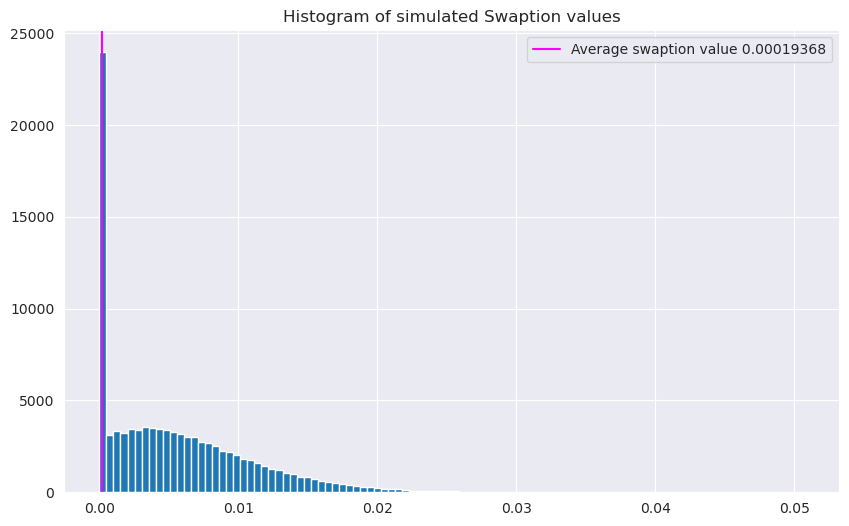

Swaption estimate: 0.00019368 and standard error 0.00002
----------------------------------------------------------------------------------------------------
Black Value: 0.00019379
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


In [36]:
X0 = 0.03
B0 = 0.035
K = 0.025
sigma = 0.2
T1 = 1
n_steps = 100 

n_sims = 100000


paths = GBM_SR(X0, sigma, T1, n_sims, n_steps)


endpoints = paths[:,-1] #Only care about the endpoint


SR_values = np.maximum(endpoints - K, 0)


swaption_estimate = B0*np.mean(SR_values)


std_err = np.std(SR_values)/np.sqrt(n_sims)

plt.figure(figsize = (10,6))
plt.hist(SR_values, bins=100)
plt.axvline(swaption_estimate, label = f'Average swaption value {swaption_estimate:.8f}', color = 'magenta')
plt.title('Histogram of simulated Swaption values')
plt.legend()
# plt.axvline(call_value_estimate, color = 'red', label = f'Average call payout ${call_value_estimate:.2f}')
plt.show()

print(f'Swaption estimate: {swaption_estimate:.8f} and standard error {std_err:.5f}')

print('-'*100)

print(f'Black Value: {payers_swaption(B0, X0, K, sigma, T1):.8f}')


print('-'*100)
print('-'*100)